# Gram-schmidt and the KF

In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [7]:
%config InlineBackend.figure_format = "retina"

## The best linear unbiased predictor for a signal plus noise model

$$
    {\bf A}_\text{opt} = \arg\min_{\bf A}\| f_t - {\bf A}\,y_{1:t} \|_2^2
$$

In [47]:
def ssm(key, signal_init, n_steps, qt, rt):
    def ssm_step(signal_prev, key):
        key_measurement, key_state = jax.random.split(key)
        ut = jax.random.normal(key_state) * qt
        et = jax.random.normal(key_measurement) * rt

        signal = signal_prev + ut
        measurement = signal + et

        return signal, (signal, measurement)

    keys = jax.random.split(key, n_steps)
    _, (signals, measurements) = jax.lax.scan(ssm_step, signal_init, keys)
    return signals, measurements

In [48]:
key = jax.random.PRNGKey(314)

In [49]:
signals, measurements = ssm(key, 0.0, 100, 0.05, 0.1)

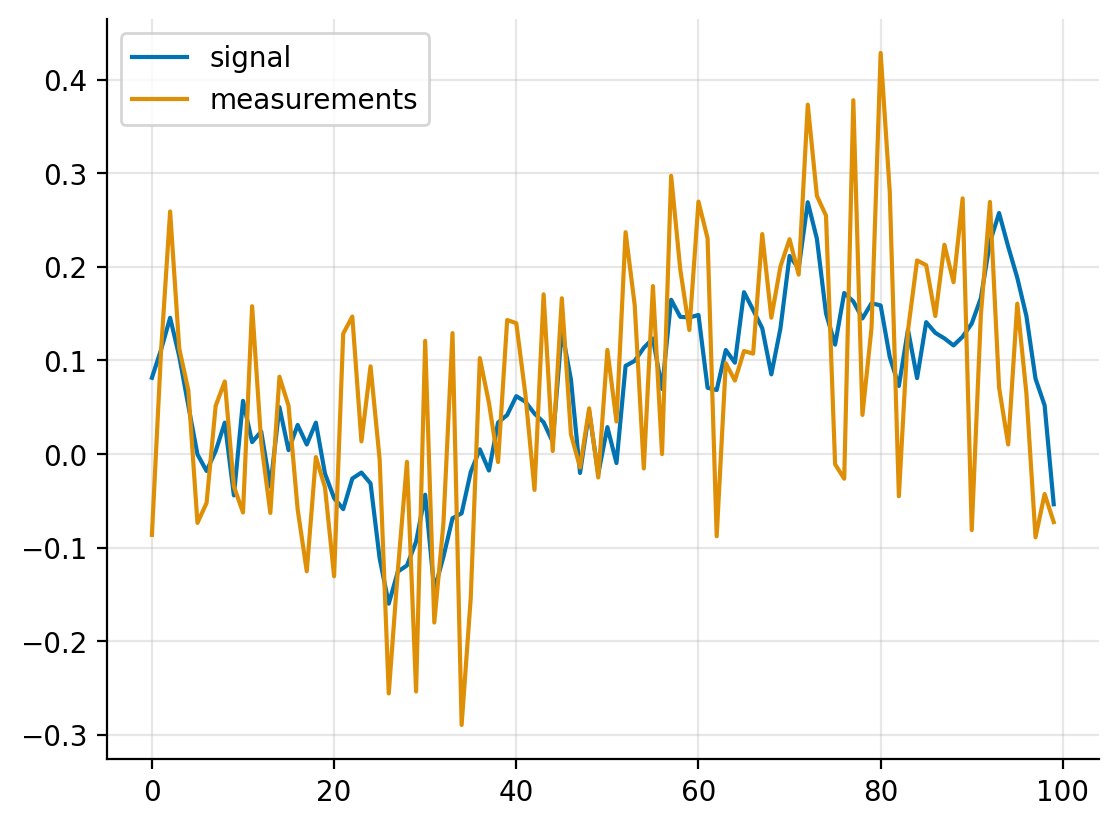

In [50]:
plt.plot(signals, label="signal")
plt.plot(measurements, label="measurements")
plt.legend()
plt.grid(alpha=0.3)

In [52]:
n_trials = 100
vssm = jax.vmap(ssm, in_axes=(0, None, None, None, None))

In [53]:
keys = jax.random.split(key, 5)

In [ ]:
vssm(keys, )

In [11]:
cov = np.cov(f, y, ddof=0, rowvar=False)
cov

array([[1.07501336, 0.02130866],
       [0.02130866, 0.010121  ]])

In [12]:
cov_fy = cov[0, 1]
var_y = cov[1, 1]
var_f = cov[0, 0]

In [13]:
# Best linear unbiased predictor
blup = cov_fy / var_y
blup

2.1053912229598666

In [14]:
# Error covariance matrix
var_blup = var_f - blup ** 2 * var_y
np.sqrt(var_blup)

1.0149632052763964

## 2d example

In [10]:
np.set_printoptions(suppress=True)

In [320]:
np.random.seed(314)
n_samples = 1000

C = np.array([5, -5])
f = np.random.randn(n_samples, 2)
e = np.random.randn(n_samples) * 1.0

y = np.einsum("m,sm->s", C, f) + e # signal + noise

In [321]:
cov = np.cov(np.c_[f, y], rowvar=False)
cov

array([[ 1.03637422, -0.03071531,  5.31737454],
       [-0.03071531,  1.02426086, -5.25233804],
       [ 5.31737454, -5.25233804, 53.69804633]])

In [322]:
Aopt = cov[-1, :2] / cov[-1, -1]
Aopt

array([ 0.09902361, -0.09781246])

In [319]:
fhat = np.einsum("s,m->sm", y, Aopt)

In [311]:
cov[:2, :2] - np.outer(Aopt, Aopt) / var_y

array([[0.06752923, 0.92627979],
       [0.92627979, 0.07897071]])

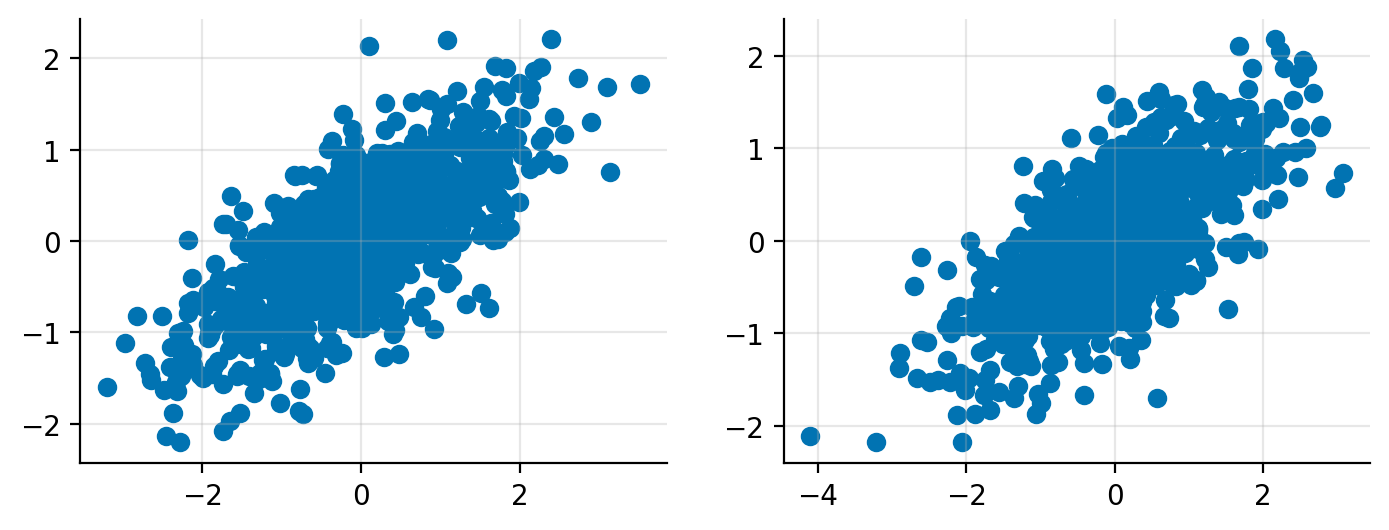

In [312]:
fig, axs = plt.subplots(1, 2, figsize=(6.4 * 1.3, 4.8 * 0.6))
for ix, ax in enumerate(axs):
    ax.scatter(f[:, ix], fhat[:, ix])
    ax.grid(alpha=0.3)